In [179]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score

In [132]:
with open(f'../python/methods.py', 'r') as file:
    exec(file.read())

In [133]:
samples = pd.read_csv('../sample_sheet.csv')
samples = samples[samples['SampleID'] == 'S2']

In [134]:
samples

,SID,Run,SampleID,URL,Age,Sex,DominantHand
0,S2_run1,run1,S2,https://osf.io/download/n2wgu,33,Male,Right
1,S2_run2,run2,S2,https://osf.io/download/5z92u,33,Male,Right
2,S2_run3,run3,S2,https://osf.io/download/vn64p,33,Male,Right
3,S2_run4,run4,S2,https://osf.io/download/98hzm,33,Male,Right
4,S2_run5,run5,S2,https://osf.io/download/ue35a,33,Male,Right
5,S2_run6,run6,S2,https://osf.io/download/df6ab,33,Male,Right
6,S2_run7,run7,S2,https://osf.io/download/tfs54,33,Male,Right
7,S2_run8,run8,S2,https://osf.io/download/3qebs,33,Male,Right
8,S2_run9,run9,S2,https://osf.io/download/2bers,33,Male,Right
9,S2_run10,run10,S2,https://osf.io/download/2dnmy,33,Male,Right


In [135]:
# Read and merge all feature matrices
feature_matrix = pd.DataFrame()
for index, sample in samples.iterrows():
    sampleId = sample['SampleID']
    run = sample['Run']
    file = f'../output/problem-at-hand/{sampleId}/{run}/feature_matrix.csv'
    print(f'Reading feature matrix: {file}')
    data = pd.read_csv(file, index_col = 0)
    feature_matrix = pd.concat([feature_matrix, data], axis = 1)

print(f'Data dimensions after merging all runs: {feature_matrix.shape}')

# Read and merge information about features
feature_info = pd.DataFrame()
for index, sample in samples.iterrows():
    sampleId = sample['SampleID']
    run = sample['Run']
    file = f'../output/problem-at-hand/{sampleId}/{run}/feature_key.csv'
    print(f'Reading feature info: {file}')
    data = pd.read_csv(file)
    feature_info = pd.concat([feature_info, data])

feature_info = feature_info.drop_duplicates()
print(f'Number of unique features after merging all runs: {len(feature_info)}')
assert len(feature_info) == feature_matrix.shape[0]

# Merging and separating both tables to make sure the indexes match
merged = pd.merge(feature_info, feature_matrix, left_on = 'FeatureID', right_index = True)
merged.index = merged['FeatureID']
feature_info = merged[['FeatureID', 'Channel', 'Frequency']]
feature_matrix = merged[merged.columns[3:]]

assert len(feature_info) == feature_matrix.shape[0]
assert all(feature_info['FeatureID'] == feature_matrix.index)

# Read and merge information about events
event_info = pd.DataFrame()
for index, sample in samples.iterrows():
    sampleId = sample['SampleID']
    run = sample['Run']
    file = f'../output/problem-at-hand/{sampleId}/{run}/event_key.csv'
    print(f'Reading event info: {file}')
    data = pd.read_csv(file)
    event_info = pd.concat([event_info, data])

event_info = event_info.drop_duplicates()
print(f'Number of unique events after merging all runs: {len(event_info)}')
assert len(event_info) == feature_matrix.shape[1]

print('Selecting only finger movement data')
event_info = event_info[event_info['Event'] != 0]

event_info['Event'].value_counts()

# Ensure that columns match
feature_matrix = feature_matrix[event_info['EventID']]

assert len(event_info) == feature_matrix.shape[1]
assert all(event_info['EventID'] == feature_matrix.columns)

print(f'Number of unique events: {len(event_info)}')
print(f'Number of unique features: {len(feature_info)}')

print('Filtering out power line frequencies')
freq_step = 5
keep = np.logical_or(
    feature_info['Frequency'] < 50 - freq_step + 1,
    feature_info['Frequency'] > 70
)

feature_info = feature_info[keep]
feature_matrix = feature_matrix[keep]

assert len(feature_info) == feature_matrix.shape[0]
assert all(feature_info['FeatureID'] == feature_matrix.index)
assert len(event_info) == feature_matrix.shape[1]
assert all(event_info['EventID'] == feature_matrix.columns)

print(f'Number of unique features after removing power line features: {len(feature_info)}')

Reading feature matrix: ../output/problem-at-hand/S2/run1/feature_matrix.csv
Reading feature matrix: ../output/problem-at-hand/S2/run2/feature_matrix.csv
Reading feature matrix: ../output/problem-at-hand/S2/run3/feature_matrix.csv
Reading feature matrix: ../output/problem-at-hand/S2/run4/feature_matrix.csv
Reading feature matrix: ../output/problem-at-hand/S2/run5/feature_matrix.csv
Reading feature matrix: ../output/problem-at-hand/S2/run6/feature_matrix.csv
Reading feature matrix: ../output/problem-at-hand/S2/run7/feature_matrix.csv
Reading feature matrix: ../output/problem-at-hand/S2/run8/feature_matrix.csv
Reading feature matrix: ../output/problem-at-hand/S2/run9/feature_matrix.csv
Reading feature matrix: ../output/problem-at-hand/S2/run10/feature_matrix.csv
Data dimensions after merging all runs: (6144, 4152)
Reading feature info: ../output/problem-at-hand/S2/run1/feature_key.csv
Reading feature info: ../output/problem-at-hand/S2/run2/feature_key.csv
Reading feature info: ../output/

In [136]:
feature_matrix.values.shape

(4608, 2498)

In [137]:
x = feature_matrix.values
x = np.log(x)
x = (x.T - np.mean(x, axis = 1)) / np.std(x, axis = 1)

In [138]:
# Data was transposed
assert len(feature_info) == x.shape[1]
assert len(event_info) == x.shape[0]

In [139]:
y = LabelEncoder().fit_transform(event_info['Event'])

assert len(y) == len(event_info)
assert len(y) == x.shape[0]

In [161]:
param_grid = {
    'max_depth': [2, 4, 8, 16, 32, 64],
    'n_estimators': [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
}

model = RandomForestClassifier(
    random_state = 154,
    criterion = 'log_loss',
    n_jobs = 4
)
grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = 'f1_macro', verbose = 3, n_jobs = 2)
grid_search.fit(x, y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 2/5] END .......max_depth=2, n_estimators=2;, score=0.152 total time=   0.1s
[CV 3/5] END .......max_depth=2, n_estimators=2;, score=0.141 total time=   0.1s
[CV 5/5] END .......max_depth=2, n_estimators=2;, score=0.123 total time=   0.1s
[CV 2/5] END .......max_depth=2, n_estimators=4;, score=0.152 total time=   0.1s
[CV 4/5] END .......max_depth=2, n_estimators=4;, score=0.145 total time=   0.1s
[CV 1/5] END .......max_depth=2, n_estimators=8;, score=0.189 total time=   0.1s
[CV 3/5] END .......max_depth=2, n_estimators=8;, score=0.149 total time=   0.1s
[CV 5/5] END .......max_depth=2, n_estimators=8;, score=0.188 total time=   0.1s
[CV 2/5] END ......max_depth=2, n_estimators=16;, score=0.164 total time=   0.2s
[CV 4/5] END ......max_depth=2, n_estimators=16;, score=0.176 total time=   0.2s
[CV 1/5] END ......max_depth=2, n_estimators=32;, score=0.180 total time=   0.4s
[CV 3/5] END ......max_depth=2, n_estimators=32

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(criterion='log_loss', n_jobs=4,
                                              random_state=154),
             n_jobs=2,
             param_grid={'max_depth': [2, 4, 8, 16, 32, 64],
                         'n_estimators': [2, 4, 8, 16, 32, 64, 128, 256, 512,
                                          1024]},
             scoring='f1_macro', verbose=3)

In [163]:
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'max_depth': 16, 'n_estimators': 2}
Best score:  0.21011220006410108


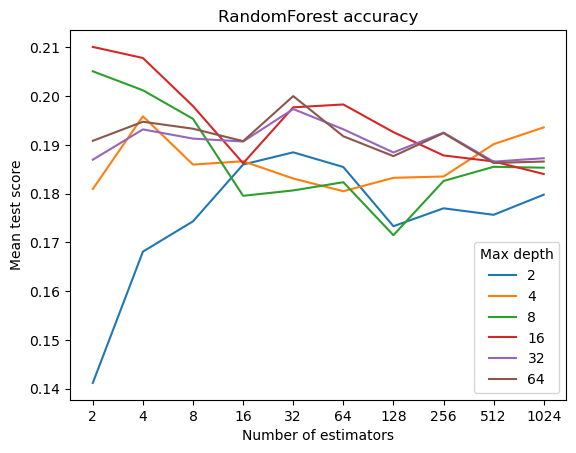

In [189]:
n_estimators = grid_search.best_params_['n_estimators']
results = pd.DataFrame(grid_search.cv_results_)

for max_depth in np.sort(np.unique(results['param_max_depth'])):
    res = results[results['param_max_depth'] == max_depth]
    plt.plot(np.log(res['param_n_estimators'].astype(float)), res['mean_test_score'], label = max_depth)

plt.legend(title = 'Max depth', loc = 'lower right')
plt.xticks(np.log([2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]), np.array([2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]))
plt.title('RandomForest accuracy')
plt.xlabel('Number of estimators')
plt.ylabel('Mean test score')
plt.show()

In [168]:
def create_splits(x, y, n_splits = 5):
    validator = StratifiedKFold(n_splits = n_splits, random_state = 42, shuffle = True)

    splits = []
    for train_ix, test_ix in validator.split(x, y):
        x_train, y_train = x[train_ix], y[train_ix]
        x_test, y_test = x[test_ix], y[test_ix]
        splits.append([x_train, y_train, x_test, y_test])

    return splits

In [169]:
# Prepare splits
splits = create_splits(x, y)

In [175]:
max_depth = grid_search.best_params_['max_depth']
n_estimators = grid_search.best_params_['n_estimators']

print(f'max_depth {max_depth}')
print(f'n_estimators {n_estimators}')

max_depth 16
n_estimators 2


In [176]:
random_forest_fingers = []
for split in splits:
    print('Starting another split')
    x_train, y_train, x_test, y_test = split

    model = RandomForestClassifier(
        random_state = 154,
        criterion = 'log_loss',
        n_estimators = n_estimators,
        max_depth = max_depth,
        n_jobs = 6
    )

    model.fit(x_train, y_train)

    print(f'Model training accuracy: {model.score(x_train, y_train)}')
    print(f'Model testing accuracy: {model.score(x_test, y_test)}')

    random_forest_fingers.append(model)

Starting another split
Model training accuracy: 0.6631631631631631
Model testing accuracy: 0.212
Starting another split
Model training accuracy: 0.7152152152152152
Model testing accuracy: 0.21
Starting another split
Model training accuracy: 0.6861861861861862
Model testing accuracy: 0.222
Starting another split
Model training accuracy: 0.6908454227113556
Model testing accuracy: 0.22645290581162325
Starting another split
Model training accuracy: 0.7178589294647324
Model testing accuracy: 0.22444889779559118


In [180]:
def calculate_model_metrics(models, model_splits):
    model_results = []

    for model_i, split_i in zip(models, model_splits):
        train_x, train_y, test_x, test_y = split_i

        predicted_y = model_i.predict(test_x)

        model_results.append({
            'Accuracy': model_i.score(test_x, test_y),
            'TrainAccuracy': model_i.score(train_x, train_y),
            'MeanPrecisionPerClass': np.mean(precision_score(test_y, predicted_y, average = None)),
            'MeanRecallPerClass': np.mean(recall_score(test_y, predicted_y, average = None))
        })

    return pd.DataFrame(model_results)

In [181]:
random_forest_eval = calculate_model_metrics(models = random_forest_fingers, model_splits = splits)

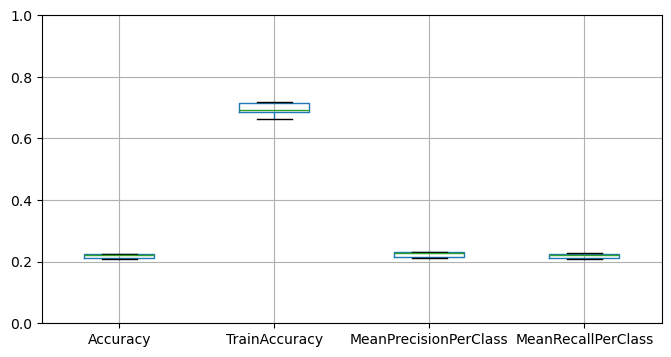

In [182]:
plt.figure(figsize = (8, 4))
random_forest_eval.boxplot()
plt.ylim(0, 1)
plt.show()

In [183]:
best_model_idx = np.argmax(random_forest_eval['Accuracy'])
model = random_forest_fingers[best_model_idx]
split = splits[best_model_idx]
x_train, y_train, x_test, y_test = split

In [184]:
print(f'Model training accuracy: {model.score(x_train, y_train)}')
print(f'Model testing accuracy: {model.score(x_test, y_test)}')

Model training accuracy: 0.6908454227113556
Model testing accuracy: 0.22645290581162325


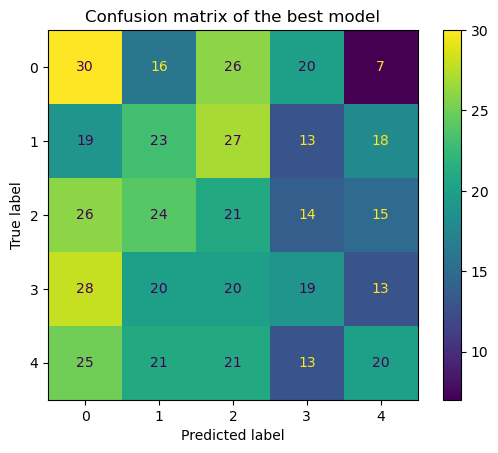

In [185]:
predicted = model.predict(x_test)
cm = confusion_matrix(y_test, predicted, labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.title('Confusion matrix of the best model')
plt.show()

In [187]:
np.mean(random_forest_eval['Accuracy'])

0.2189803607214429

In [188]:
np.mean(random_forest_eval['TrainAccuracy'])

0.6946537833481305